This code is written by [Ali Haghighi](https://hellotherebeautiful.vercel.app/), for the course of remote sensing, Fall 2025 taught by [Dr. Parviz Fatehi](https://profile.ut.ac.ir/en/~parviz.fatehi).


# Land Surface Temperature (LST) Analysis from Landsat 5 TM

This notebook performs a comprehensive analysis of Land Surface Temperature (LST) from Landsat 5 TM satellite imagery using Google Earth Engine.

## Overview

The analysis includes:
1. **Natural RGB Image** - True color visualization of the scene
2. **False Color Composite** - Vegetation analysis using NIR-Red-Green bands
3. **Raw Band 6 Image** - Thermal infrared band visualization
4. **LST Calculation** - Conversion from digital numbers to temperature in Celsius
5. **Full Scene LST Map** - Temperature distribution across the entire scene
6. **Zoomed LST Map on Rasht** - Detailed temperature analysis for Rasht city area
7. **Temperature Histogram** - Statistical distribution of land surface temperatures

## Data Source
- **Satellite**: Landsat 5 Thematic Mapper (TM)
- **Collection**: LANDSAT/LT05/C02/T1 (Collection 2, Tier 1)
- **Scene**: LT51660341987186XXX02 (July 5, 1987)


## 1. Setup and Imports

Import required libraries and initialize Google Earth Engine.


In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, Image
import urllib.request
import io
from PIL import Image as PILImage

# Initialize Google Earth Engine
try:
    ee.Initialize(project='surface-hydrology')
    print("✓ Google Earth Engine initialized successfully.")
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("You may need to run: ee.Authenticate()")
    raise

# Set matplotlib parameters for high-quality plots
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#FF5F05", "#13294B", "#009FD4", "#FCB316", "#006230", "#007E8E", "#5C0E41", "#7D3E13"])


c:\Users\alihg\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.7) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


✓ Google Earth Engine initialized successfully.


## 2. Load Scene Information

Define the Landsat scene parameters and load the image from Google Earth Engine.


In [2]:
# Define scene information
scene_id = 'LT51660341987186XXX02'
collection_id = 'LANDSAT/LT05/C02/T1'
date_acquired = '1987-07-05'
cloud_cover = 0

print("=" * 60)
print("SCENE INFORMATION")
print("=" * 60)
print(f"Scene ID: {scene_id}")
print(f"Date Acquired: {date_acquired}")
print(f"Cloud Cover: {cloud_cover}%")
print(f"Collection: {collection_id}")
print("=" * 60)

# Load the specific image from the collection
image = (ee.ImageCollection(collection_id)
         .filter(ee.Filter.eq('LANDSAT_SCENE_ID', scene_id))
         .first())

# Verify the image exists
try:
    image_id = image.get('system:id').getInfo()
    print(f"\nâœ“ Successfully loaded image: {image_id}")
except Exception as e:
    print(f"Error loading image: {e}")
    raise ValueError("Could not load the image. Please check the scene ID.")

# Get image geometry and native projection
aoi = image.geometry()
native_crs = image.select(0).projection().crs().getInfo()
print(f"Native CRS: {native_crs}")

SCENE INFORMATION
Scene ID: LT51660341987186XXX02
Date Acquired: 1987-07-05
Cloud Cover: 0%
Collection: LANDSAT/LT05/C02/T1

âœ“ Successfully loaded image: LANDSAT/LT05/C02/T1/LT05_166034_19870705
Native CRS: EPSG:32639


## 3. Natural RGB Image (True Color)

Display the scene in natural color using bands B3 (Red), B2 (Green), and B1 (Blue). This provides a true-color representation similar to what the human eye would see.


Computing statistics for RGB visualization...
Band 3 (Red) range: 20.00 - 87.00
Band 2 (Green) range: 28.00 - 70.00
Band 1 (Blue) range: 69.00 - 131.00

Preparing RGB visualization...
  Attempting download at 30m resolution...
  Image too large at 30m, trying higher scale...
  Attempting download at 60m resolution...
  Image too large at 60m, trying higher scale...
  Attempting download at 120m resolution...
✓ Image downloaded successfully at 120m resolution: shape (1984, 1796)


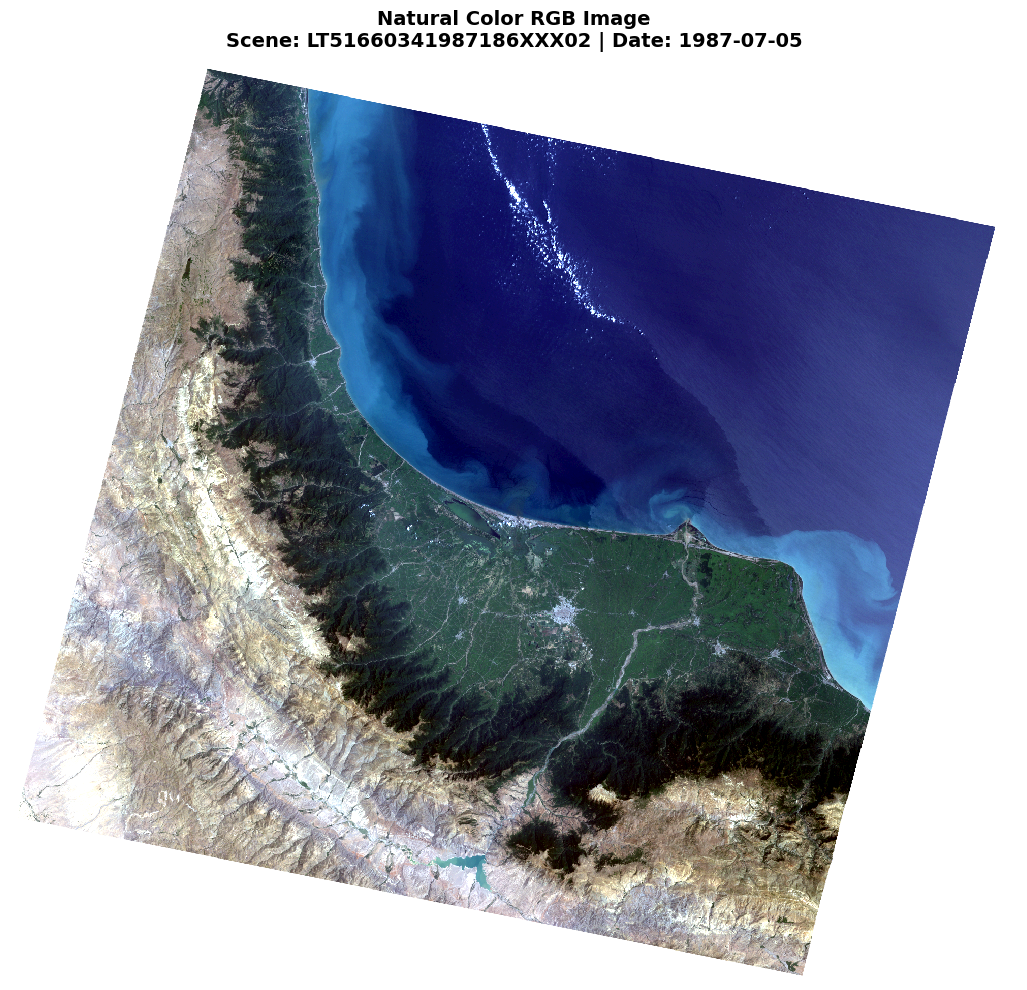

In [3]:
# Select RGB bands for true color
# Landsat 5 TM: B1=Blue, B2=Green, B3=Red
rgb_bands = ['B3', 'B2', 'B1']  # Red, Green, Blue
rgb_image = image.select(rgb_bands)

# Compute percentiles for proper stretching (2nd-98th percentiles)
print("Computing statistics for RGB visualization...")
percentiles = rgb_image.select(rgb_bands).reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=30,  # 30m resolution for visible bands
    maxPixels=1e9
).getInfo()

# Extract min and max values for each band
b3_min = percentiles.get('B3_p2', 0)
b3_max = percentiles.get('B3_p98', 255)
b2_min = percentiles.get('B2_p2', 0)
b2_max = percentiles.get('B2_p98', 255)
b1_min = percentiles.get('B1_p2', 0)
b1_max = percentiles.get('B1_p98', 255)

print(f"Band 3 (Red) range: {b3_min:.2f} - {b3_max:.2f}")
print(f"Band 2 (Green) range: {b2_min:.2f} - {b2_max:.2f}")
print(f"Band 1 (Blue) range: {b1_min:.2f} - {b1_max:.2f}")

# Visualize RGB image for download
print("\nPreparing RGB visualization...")
rgb_visualized = rgb_image.visualize(
    bands=rgb_bands,
    min=[b3_min, b2_min, b1_min],
    max=[b3_max, b2_max, b1_max],
    gamma=1.2
)

# Download and display image with progressive scale fallback
print("Downloading image...")
scales_to_try = [30, 60, 120, 240, 480, 960]
img = None
successful_scale = None

for scale in scales_to_try:
    try:
        print(f"  Attempting download at {scale}m resolution...")
        download_url = rgb_visualized.getDownloadURL({
            'scale': scale,
            'crs': native_crs,
            'region': aoi,
            'format': 'PNG'
        })
        
        response = urllib.request.urlopen(download_url)
        img_data = response.read()
        img = PILImage.open(io.BytesIO(img_data))
        successful_scale = scale
        print(f"✓ Image downloaded successfully at {successful_scale}m resolution: shape {img.size}")
        break
    except Exception as e:
        error_msg = str(e)
        if "must be less than or equal to" in error_msg or "Total request size" in error_msg:
            if scale < scales_to_try[-1]:
                print(f"  Image too large at {scale}m, trying higher scale...")
                continue
            else:
                print(f"  Error: Image still too large even at {scale}m resolution.")
                raise
        else:
            print(f"  Error at {scale}m: {e}")
            if scale == scales_to_try[-1]:
                raise
            continue

if img is None:
    raise Exception("Failed to download image at any scale")

# Display the image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(img, interpolation='nearest', aspect='equal')
ax.set_title(f'Natural Color RGB Image\nScene: {scene_id} | Date: {date_acquired}', 
                 fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


## 4. False Color Composite

Display a false color composite using bands B4 (Near Infrared), B3 (Red), and B2 (Green). This combination is useful for vegetation analysis, where healthy vegetation appears in bright red/magenta colors.


Computing statistics for false color visualization...
Band 4 (NIR) range: 13.00 - 123.00
Band 3 (Red) range: 20.00 - 87.00
Band 2 (Green) range: 28.00 - 70.00

Preparing false color visualization...
  Attempting download at 30m resolution...
  Image too large at 30m, trying higher scale...
  Attempting download at 60m resolution...
  Image too large at 60m, trying higher scale...
  Attempting download at 120m resolution...
✓ Image downloaded successfully at 120m resolution: shape (1984, 1796)


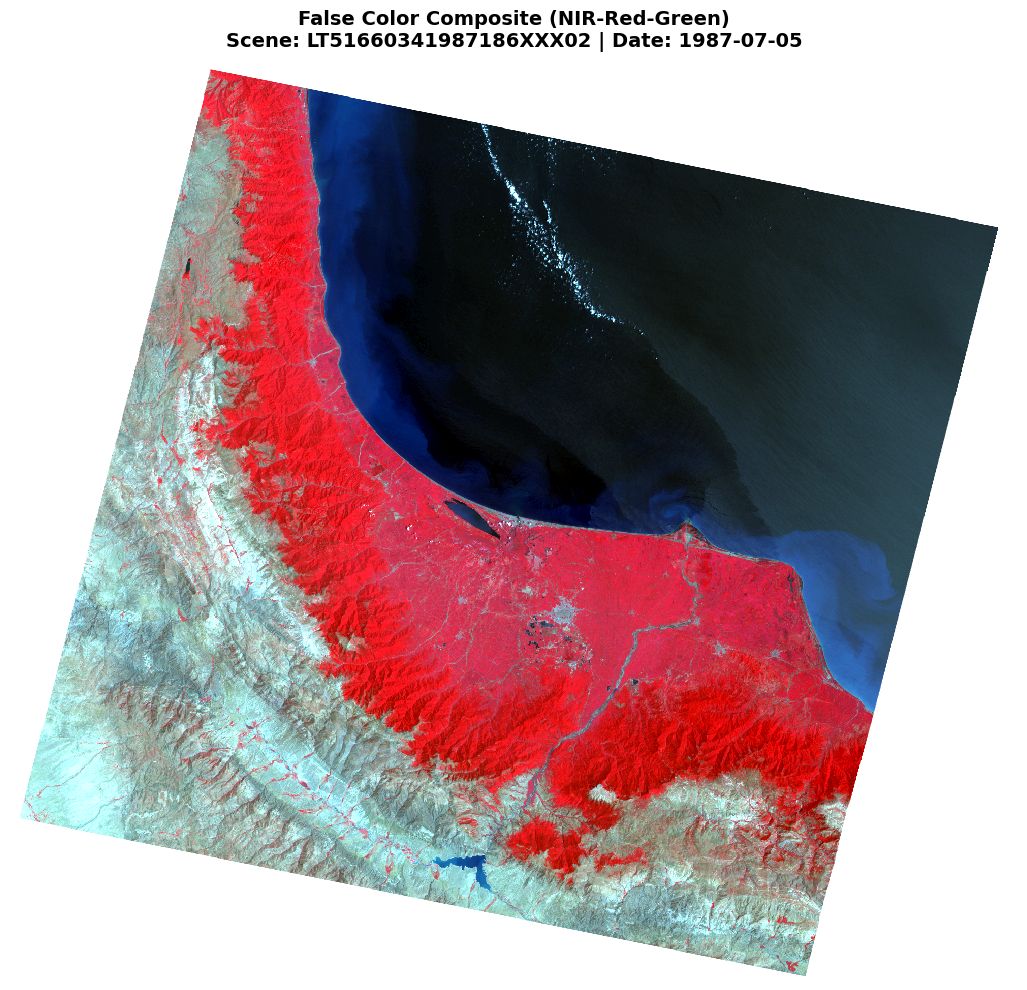

In [4]:
# Select false color bands: B4 (NIR), B3 (Red), B2 (Green)
false_color_bands = ['B4', 'B3', 'B2']  # NIR, Red, Green
false_color_image = image.select(false_color_bands)

# Compute percentiles for false color visualization
print("Computing statistics for false color visualization...")
false_color_percentiles = false_color_image.select(false_color_bands).reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

b4_min = false_color_percentiles.get('B4_p2', 0)
b4_max = false_color_percentiles.get('B4_p98', 255)

print(f"Band 4 (NIR) range: {b4_min:.2f} - {b4_max:.2f}")
print(f"Band 3 (Red) range: {b3_min:.2f} - {b3_max:.2f}")
print(f"Band 2 (Green) range: {b2_min:.2f} - {b2_max:.2f}")

# Visualize false color image
print("\nPreparing false color visualization...")
false_color_visualized = false_color_image.visualize(
    bands=false_color_bands,
    min=[b4_min, b3_min, b2_min],
    max=[b4_max, b3_max, b2_max],
    gamma=1.2
)

# Download and display image with progressive scale fallback
print("Downloading image...")
scales_to_try = [30, 60, 120, 240, 480, 960]
img = None
successful_scale = None

for scale in scales_to_try:
    try:
        print(f"  Attempting download at {scale}m resolution...")
        download_url = false_color_visualized.getDownloadURL({
            'scale': scale,
            'crs': native_crs,
            'region': aoi,
            'format': 'PNG'
        })
        
        response = urllib.request.urlopen(download_url)
        img_data = response.read()
        img = PILImage.open(io.BytesIO(img_data))
        successful_scale = scale
        print(f"✓ Image downloaded successfully at {successful_scale}m resolution: shape {img.size}")
        break
    except Exception as e:
        error_msg = str(e)
        if "must be less than or equal to" in error_msg or "Total request size" in error_msg:
            if scale < scales_to_try[-1]:
                print(f"  Image too large at {scale}m, trying higher scale...")
                continue
            else:
                print(f"  Error: Image still too large even at {scale}m resolution.")
                raise
        else:
            print(f"  Error at {scale}m: {e}")
            if scale == scales_to_try[-1]:
                raise
            continue

if img is None:
    raise Exception("Failed to download image at any scale")

# Display the image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(img, interpolation='nearest', aspect='equal')
ax.set_title(f'False Color Composite (NIR-Red-Green)\nScene: {scene_id} | Date: {date_acquired}', 
                 fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


## 5. Raw Band 6 Image (Thermal Infrared)

Display Band 6 in grayscale. This is the thermal infrared band (10.4-12.5 µm) used for temperature calculations. The native resolution is 120m, but it's resampled to 30m for visualization consistency.


Band 6 selected (120m native resolution)
Computing Band 6 statistics...
Band 6 DN range: 131 - 184

Preparing Band 6 visualization...
  Attempting download at 30m resolution...
  Image too large at 30m, trying higher scale...
  Attempting download at 60m resolution...
  Image too large at 60m, trying higher scale...
  Attempting download at 120m resolution...
✓ Image downloaded successfully at 120m resolution: shape (1984, 1796)


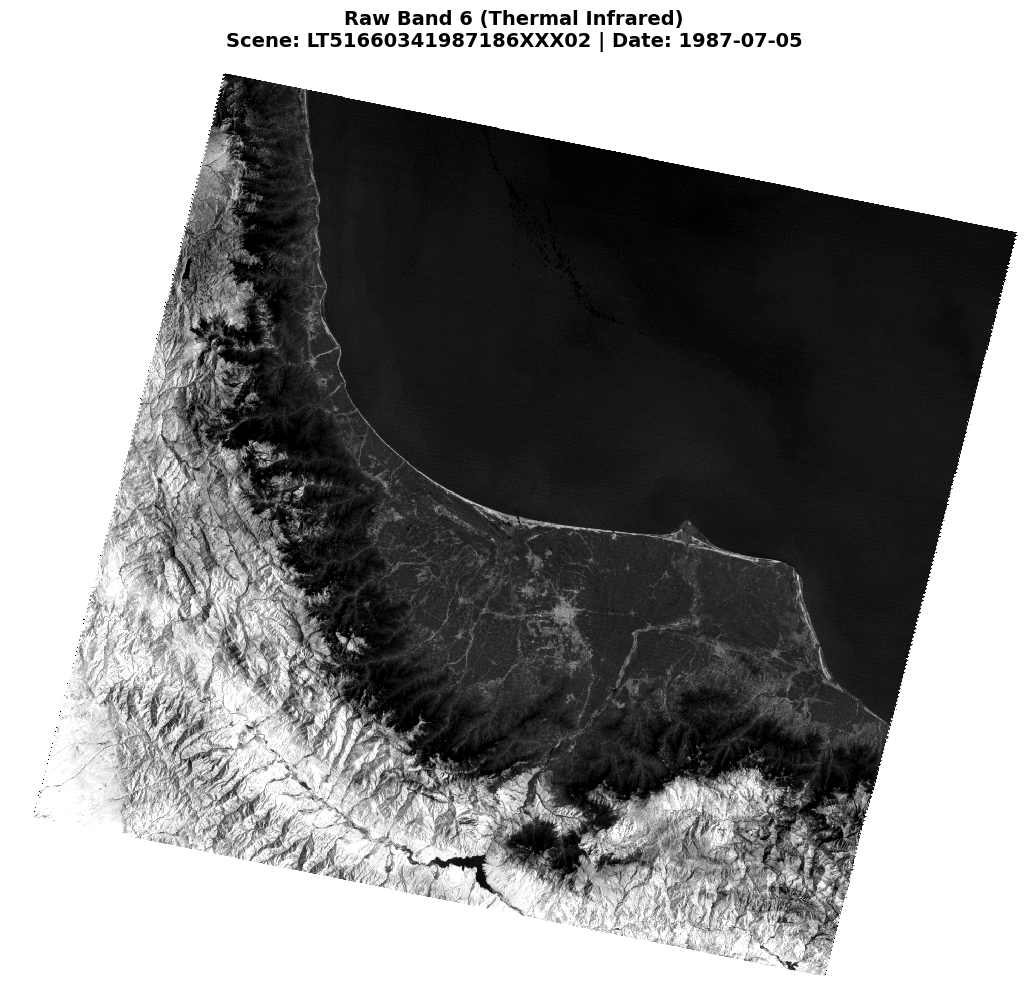

In [5]:
# Select Band 6 (thermal infrared)
band6 = image.select('B6')
print("Band 6 selected (120m native resolution)")

# Compute DN statistics (2nd-98th percentiles)
print("Computing Band 6 statistics...")
b6_stats = band6.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=120,  # Native resolution
    maxPixels=1e9
).getInfo()

b6_min = b6_stats.get('B6_p2', 0)
b6_max = b6_stats.get('B6_p98', 255)

print(f"Band 6 DN range: {b6_min:.0f} - {b6_max:.0f}")

# Resample B6 to 30m for consistency with other outputs
band6_30m = band6.resample('bilinear').reproject(
    crs=native_crs,
    scale=30
)

# Visualize Band 6 as grayscale
print("\nPreparing Band 6 visualization...")
band6_visualized = band6_30m.visualize(
    bands=['B6'],
    min=b6_min,
    max=b6_max,
    palette=['black', 'white']
)

# Download and display image with progressive scale fallback
print("Downloading image...")
scales_to_try = [30, 60, 120, 240, 480, 960]
img = None
successful_scale = None

for scale in scales_to_try:
    try:
        print(f"  Attempting download at {scale}m resolution...")
        download_url = band6_visualized.getDownloadURL({
            'scale': scale,
            'crs': native_crs,
            'region': aoi,
            'format': 'PNG'
        })
        
        response = urllib.request.urlopen(download_url)
        img_data = response.read()
        img = PILImage.open(io.BytesIO(img_data))
        successful_scale = scale
        print(f"✓ Image downloaded successfully at {successful_scale}m resolution: shape {img.size}")
        break
    except Exception as e:
        error_msg = str(e)
        if "must be less than or equal to" in error_msg or "Total request size" in error_msg:
            if scale < scales_to_try[-1]:
                print(f"  Image too large at {scale}m, trying higher scale...")
                continue
            else:
                print(f"  Error: Image still too large even at {scale}m resolution.")
                raise
        else:
            print(f"  Error at {scale}m: {e}")
            if scale == scales_to_try[-1]:
                raise
            continue

if img is None:
    raise Exception("Failed to download image at any scale")

# Display the image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(img, cmap='gray', interpolation='nearest', aspect='equal')
ax.set_title(f'Raw Band 6 (Thermal Infrared)\nScene: {scene_id} | Date: {date_acquired}', 
                 fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


## 6. Land Surface Temperature (LST) Calculation

Calculate Land Surface Temperature from Band 6 using the following process:

1. **DN to Radiance**: Convert Digital Numbers to spectral radiance
   - Formula: `L = RADIANCE_MULT_BAND_6 Ã— B6 + RADIANCE_ADD_BAND_6`

2. **Radiance to Brightness Temperature**: Convert radiance to temperature in Kelvin
   - Formula: `T_K = K2 / ln((K1 Ã— Îµ / L) + 1)`
   - Where Îµ = 0.95 (emissivity correction factor)

3. **Kelvin to Celsius**: Convert to Celsius for easier interpretation
   - Formula: `T_C = T_K - 273.15`


In [6]:
# Extract metadata parameters from image properties
print("Extracting metadata parameters...")
try:
    rad_mult_b6 = image.get('RADIANCE_MULT_BAND_6').getInfo()
    rad_add_b6 = image.get('RADIANCE_ADD_BAND_6').getInfo()
    k1_b6 = image.get('K1_CONSTANT_BAND_6').getInfo()
    k2_b6 = image.get('K2_CONSTANT_BAND_6').getInfo()
    
    print(f"RADIANCE_MULT_BAND_6: {rad_mult_b6}")
    print(f"RADIANCE_ADD_BAND_6: {rad_add_b6}")
    print(f"K1_CONSTANT_BAND_6: {k1_b6}")
    print(f"K2_CONSTANT_BAND_6: {k2_b6}")
    
except Exception as e:
    print(f"Error extracting metadata: {e}")
    print("Trying alternative property names...")
    try:
        props = image.getInfo()['properties']
        rad_mult_b6 = props.get('RADIANCE_MULT_BAND_6')
        rad_add_b6 = props.get('RADIANCE_ADD_BAND_6')
        k1_b6 = props.get('K1_CONSTANT_BAND_6')
        k2_b6 = props.get('K2_CONSTANT_BAND_6')
        
        if not all([rad_mult_b6, rad_add_b6, k1_b6, k2_b6]):
            raise ValueError("Required metadata properties not found")
        
        print(f"RADIANCE_MULT_BAND_6: {rad_mult_b6}")
        print(f"RADIANCE_ADD_BAND_6: {rad_add_b6}")
        print(f"K1_CONSTANT_BAND_6: {k1_b6}")
        print(f"K2_CONSTANT_BAND_6: {k2_b6}")
    except Exception as e2:
        raise ValueError(f"Could not extract required metadata properties: {e2}")

print("\n" + "="*60)
print("CALCULATING LAND SURFACE TEMPERATURE")
print("="*60)

# Step 1: Convert DN to Radiance
print("\nStep 1: Converting DN to spectral radiance...")
radiance = band6.multiply(rad_mult_b6).add(rad_add_b6)

radiance_stats = radiance.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi,
    scale=120,  # Band 6 native resolution
    maxPixels=1e9
).getInfo()

rad_min = radiance_stats.get('B6_min', 0)
rad_max = radiance_stats.get('B6_max', 0)
print(f"Radiance range: {rad_min:.4f} - {rad_max:.4f} W/(mÂ²Â·srÂ·Âµm)")

# Step 2: Convert Radiance to Kelvin (with emissivity correction e=0.95)
print("\nStep 2: Converting radiance to brightness temperature (Kelvin)...")
print("Using emissivity correction factor: Îµ = 0.95")

k1_img = ee.Image.constant(k1_b6)
k2_img = ee.Image.constant(k2_b6)
emissivity = 0.95

# Calculate: T = K2 / ln((K1 * e / L) + 1)
kelvin_temp = k2_img.divide(
    k1_img.multiply(emissivity)
    .divide(radiance)
    .add(1)
    .log()
)

kelvin_temp = kelvin_temp.rename('temperature')
kelvin_stats = kelvin_temp.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=120,
    maxPixels=1e9
).getInfo()

kelvin_min = kelvin_stats.get('temperature_p2', 0)
kelvin_max = kelvin_stats.get('temperature_p98', 0)
print(f"Temperature range (Kelvin): {kelvin_min:.2f} - {kelvin_max:.2f} K")

# Step 3: Convert Kelvin to Celsius
print("\nStep 3: Converting Kelvin to Celsius...")
celsius_temp = kelvin_temp.subtract(273.15).rename('temperature')

celsius_stats = celsius_temp.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=120,
    maxPixels=1e9
).getInfo()

celsius_min = celsius_stats.get('temperature_p2', 0)
celsius_max = celsius_stats.get('temperature_p98', 0)
print(f"Temperature range (Celsius): {celsius_min:.2f} - {celsius_max:.2f} Â°C")
print("\nâœ“ LST calculation complete!")


Extracting metadata parameters...
RADIANCE_MULT_BAND_6: 0.055375
RADIANCE_ADD_BAND_6: 1.18243
K1_CONSTANT_BAND_6: 607.76
K2_CONSTANT_BAND_6: 1260.56

CALCULATING LAND SURFACE TEMPERATURE

Step 1: Converting DN to spectral radiance...
Radiance range: 1.2378 - 12.9219 W/(mÂ²Â·srÂ·Âµm)

Step 2: Converting radiance to brightness temperature (Kelvin)...
Using emissivity correction factor: Îµ = 0.95
Temperature range (Kelvin): 297.73 - 319.38 K

Step 3: Converting Kelvin to Celsius...
Temperature range (Celsius): 24.58 - 46.23 Â°C

âœ“ LST calculation complete!


## 7. Full Scene LST Map

Display the Land Surface Temperature map for the entire scene. The map uses a color scheme from blue (cold) to red (hot) to visualize temperature distribution.


Resampling LST to 30m resolution...
Preparing LST visualization...
  Attempting download at 30m resolution...
  Image too large at 30m, trying higher scale...
  Attempting download at 60m resolution...
  Image too large at 60m, trying higher scale...
  Attempting download at 120m resolution...
✓ LST map downloaded successfully at 120m resolution: shape (1984, 1796)


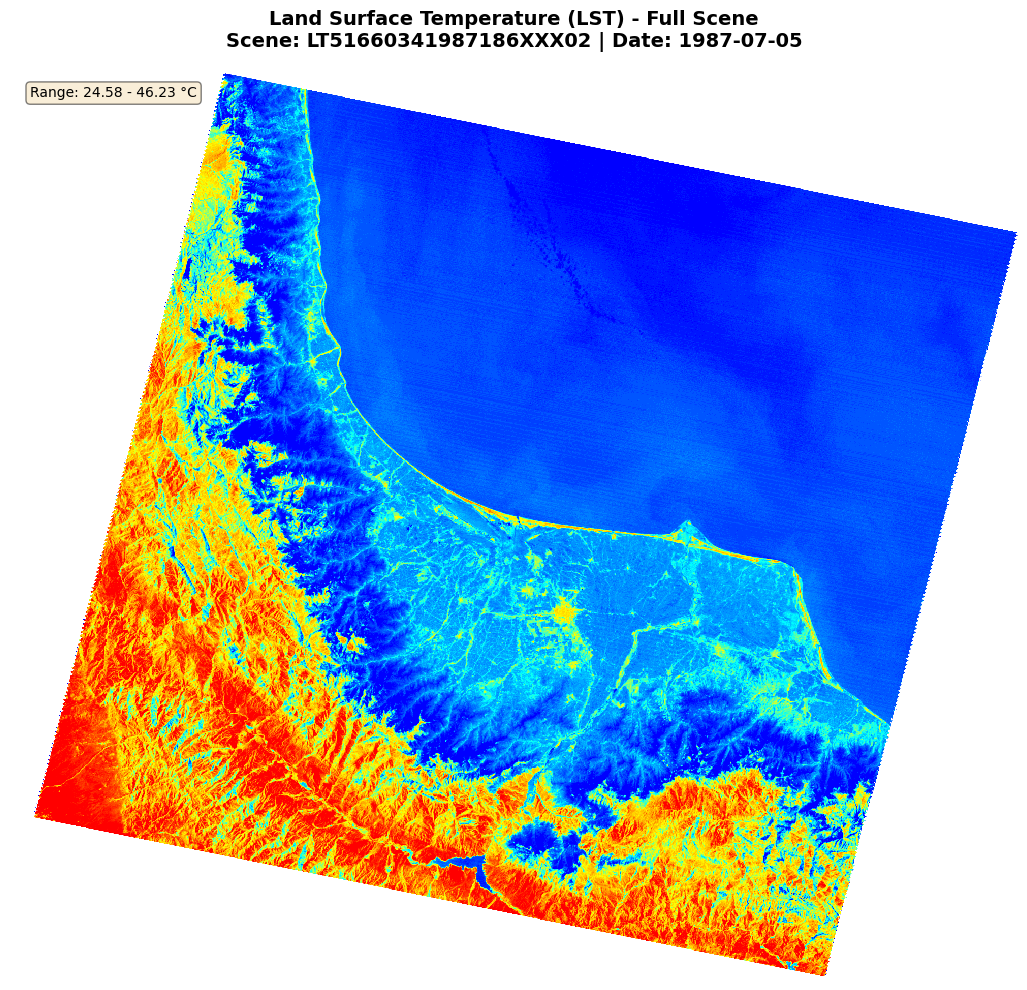

In [7]:
# Resample LST to 30m for visualization
print("Resampling LST to 30m resolution...")
celsius_temp_30m = celsius_temp.resample('bilinear').reproject(
    crs=native_crs,
    scale=30
)

# Visualize LST map
print("Preparing LST visualization...")
lst_visualized = celsius_temp_30m.visualize(
    bands=['temperature'],
    min=celsius_min,
    max=celsius_max,
    palette=['blue', 'cyan', 'yellow', 'orange', 'red']
)

# Download and display full scene LST map
print("Downloading full scene LST map...")
scales_to_try = [30, 60, 120, 240, 480, 960]
img = None
successful_scale = None

for scale in scales_to_try:
    try:
        print(f"  Attempting download at {scale}m resolution...")
        download_url = lst_visualized.getDownloadURL({
            'scale': scale,
            'crs': native_crs,
            'region': aoi,
            'format': 'PNG'
        })
        
        response = urllib.request.urlopen(download_url)
        img_data = response.read()
        img = PILImage.open(io.BytesIO(img_data))
        successful_scale = scale
        print(f"✓ LST map downloaded successfully at {successful_scale}m resolution: shape {img.size}")
        break
    except Exception as e:
        error_msg = str(e)
        if "must be less than or equal to" in error_msg or "Total request size" in error_msg:
            if scale < scales_to_try[-1]:
                print(f"  Image too large at {scale}m, trying higher scale...")
                continue
            else:
                print(f"  Error: Image still too large even at {scale}m resolution.")
                raise
        else:
            print(f"  Error at {scale}m: {e}")
            if scale == scales_to_try[-1]:
                raise
            continue

if img is None:
    raise Exception("Failed to download image at any scale")

# Display full scene LST map (WITHOUT colorbar as requested)
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(img, interpolation='nearest', aspect='equal')
ax.set_title(f'Land Surface Temperature (LST) - Full Scene\nScene: {scene_id} | Date: {date_acquired}', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.axis('off')

# Add statistics text box
stats_text = f'Range: {celsius_min:.2f} - {celsius_max:.2f} °C'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## 8. Zoomed LST Map on Rasht City

Display a detailed view of Land Surface Temperature focused on Rasht city area. Rasht is located at approximately 37.2808°N, 49.5831°E in northern Iran.


Rasht city center: 37.2808°N, 49.5831°E
Bounding box: 0.300° x 0.400°
Approximate area: ~33.3km x 44.4km
✓ Rasht area defined

Clipping LST to Rasht city area...
Computing temperature statistics for Rasht area...
Temperature range (Celsius): 27.04 - 34.68 °C
Preparing Rasht LST visualization...
  Attempting download at 30m resolution...
✓ Rasht LST map downloaded successfully at 30m resolution: shape (1199, 1128)


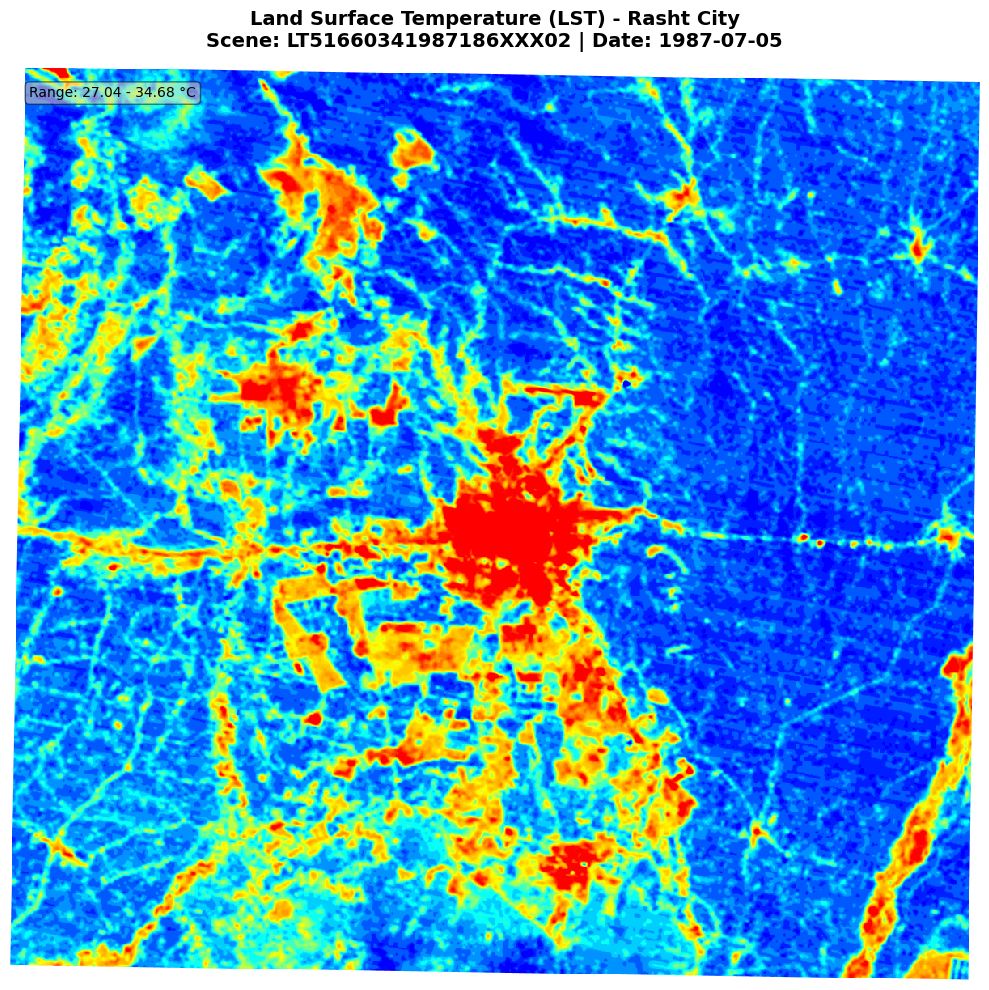

In [8]:
# Define Rasht city bounding box
rasht_center_lat = 37.2808
rasht_center_lon = 49.5831

# Define bounding box around Rasht
lat_buffer = 0.15  # degrees (approximately 16.5km)
lon_buffer = 0.2   # degrees (approximately 22km at this latitude)

rasht_bbox = ee.Geometry.Rectangle([
    rasht_center_lon - lon_buffer,  # West
    rasht_center_lat - lat_buffer,   # South
    rasht_center_lon + lon_buffer,  # East
    rasht_center_lat + lat_buffer   # North
], 'EPSG:4326')

print(f"Rasht city center: {rasht_center_lat}°N, {rasht_center_lon}°E")
print(f"Bounding box: {lat_buffer*2:.3f}° x {lon_buffer*2:.3f}°")
print(f"Approximate area: ~{lat_buffer*2*111:.1f}km x {lon_buffer*2*111:.1f}km")

# Transform Rasht bounding box to native CRS
rasht_aoi = rasht_bbox.transform(native_crs, 1)
print("✓ Rasht area defined")

# Clip LST to Rasht city area
print("\nClipping LST to Rasht city area...")
celsius_temp_rasht = celsius_temp_30m.clip(rasht_aoi)

# Compute statistics for Rasht area
print("Computing temperature statistics for Rasht area...")
rasht_stats = celsius_temp_rasht.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=rasht_aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

rasht_min = rasht_stats.get('temperature_p2', 0)
rasht_max = rasht_stats.get('temperature_p98', 0)
print(f"Temperature range (Celsius): {rasht_min:.2f} - {rasht_max:.2f} °C")

# Visualize Rasht LST map
print("Preparing Rasht LST visualization...")
rasht_lst_visualized = celsius_temp_rasht.visualize(
    bands=['temperature'],
    min=rasht_min,
    max=rasht_max,
    palette=['blue', 'cyan', 'yellow', 'orange', 'red']
)

# Download and display zoomed Rasht LST map
print("Downloading Rasht LST map...")
scales_to_try = [30, 60, 120, 240, 480, 960]
img = None
successful_scale = None

for scale in scales_to_try:
    try:
        print(f"  Attempting download at {scale}m resolution...")
        download_url = rasht_lst_visualized.getDownloadURL({
            'scale': scale,
            'crs': native_crs,
            'region': rasht_aoi,
            'format': 'PNG'
        })
        
        response = urllib.request.urlopen(download_url)
        img_data = response.read()
        img = PILImage.open(io.BytesIO(img_data))
        successful_scale = scale
        print(f"✓ Rasht LST map downloaded successfully at {successful_scale}m resolution: shape {img.size}")
        break
    except Exception as e:
        error_msg = str(e)
        if "must be less than or equal to" in error_msg or "Total request size" in error_msg:
            if scale < scales_to_try[-1]:
                print(f"  Image too large at {scale}m, trying higher scale...")
                continue
            else:
                print(f"  Error: Image still too large even at {scale}m resolution.")
                raise
        else:
            print(f"  Error at {scale}m: {e}")
            if scale == scales_to_try[-1]:
                raise
            continue

if img is None:
    raise Exception("Failed to download image at any scale")

# Display zoomed LST map for Rasht (WITHOUT colorbar as requested)
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(img, interpolation='nearest', aspect='equal')
ax.set_title(f'Land Surface Temperature (LST) - Rasht City\nScene: {scene_id} | Date: {date_acquired}', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Pixels ({successful_scale}m resolution)', fontsize=12, fontweight='bold')
ax.axis('off')

# Add statistics text box
stats_text = f'Range: {rasht_min:.2f} - {rasht_max:.2f} °C'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## 9. Temperature Histogram

Display the statistical distribution of Land Surface Temperature values. The histogram shows the frequency of different temperature ranges across the scene.


Sampling temperature values for histogram...
âœ“ Sampled 9621 temperature values
Temperature range in sample: -18.51 - 51.92 Â°C


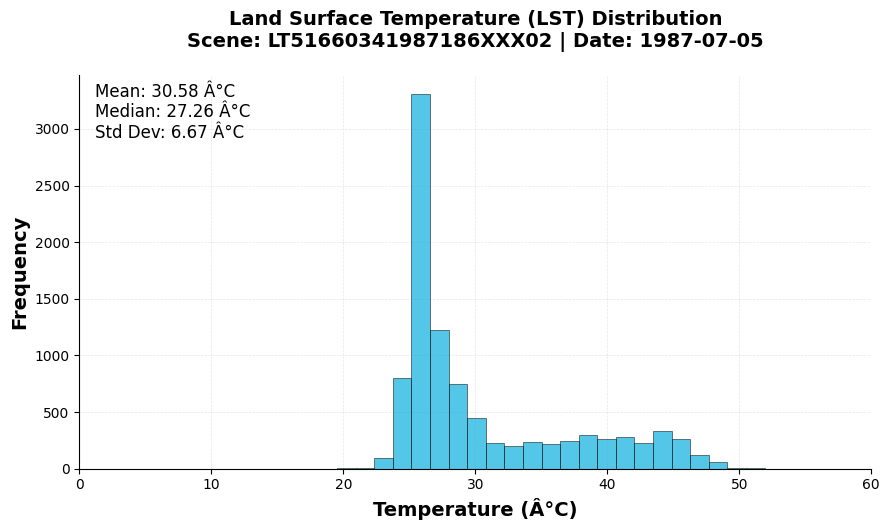

In [9]:
# Sample temperature values from the full scene for histogram
print("Sampling temperature values for histogram...")
try:
    # Use native resolution for sampling to avoid memory issues
    sample_scale = 120
    sample_points = celsius_temp.sample(
        region=aoi,
        scale=sample_scale,
        numPixels=10000,  # Sample 10,000 pixels
        seed=42
    )
    
    # Get temperature values
    temp_values = sample_points.aggregate_array('temperature').getInfo()
    temp_values = np.array(temp_values)
    
    # Filter out invalid values
    temp_values = temp_values[~np.isnan(temp_values)]
    
    print(f"âœ“ Sampled {len(temp_values)} temperature values")
    print(f"Temperature range in sample: {temp_values.min():.2f} - {temp_values.max():.2f} Â°C")
    
    # Create histogram
    fig, ax = plt.subplots(figsize=(9, 5.4))
    
    # Create histogram with custom color and edges
    n, bins, patches = ax.hist(temp_values, bins=50, color='#0baedd', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set x-axis limits from 0 to 60
    ax.set_xlim(0, 60)
    
    # Set labels and title
    ax.set_xlabel('Temperature (Â°C)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax.set_title(f'Land Surface Temperature (LST) Distribution\nScene: {scene_id} | Date: {date_acquired}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add statistics text box
    mean_temp = np.mean(temp_values)
    median_temp = np.median(temp_values)
    std_temp = np.std(temp_values)
    
    stats_text = f'Mean: {mean_temp:.2f} Â°C\nMedian: {median_temp:.2f} Â°C\nStd Dev: {std_temp:.2f} Â°C'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating histogram: {e}")
    import traceback
    traceback.print_exc()
